In [3]:
!nvidia-smi

Tue Oct 27 11:27:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Import các package cần dùng
%cd "/content/drive/My Drive/Fashion-MNIST/"
# Package giải quyết dữ liệu:
import numpy as np
import pandas as pd

# Package hỗ trợ cho model:
from sklearn.model_selection import train_test_split

# Các package hỗ trợ cho model
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

# Package cho trực quan hóa dữ liệu
import matplotlib.pyplot as plt

# Configure visualisations
%matplotlib inline
plt.style.use('fivethirtyeight')

import time

/content/drive/My Drive/Fashion-MNIST


In [5]:
# Load dữ liệu
train_set = pd.read_csv("./Dataset/fashion-mnist_train.csv").to_numpy()
test_set = pd.read_csv("./Dataset/fashion-mnist_test.csv").to_numpy()

# Tách label và data riêng cho tập train và test
X_train = train_set[:,1:]
Y_train = train_set[:,0]

X_test = test_set[:,1:]
Y_test = test_set[:,0]

In [6]:
# Reshape và chuẩn hóa dữ liệu
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train.shape, X_test.shape

X_train = X_train / 255.
X_test = X_test / 255.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
# One hot encoding cho label
Y_train_one_hot_encoding = to_categorical(Y_train)
Y_test_one_hot_encoding = to_categorical(Y_test)

Y_train_one_hot_encoding.shape, Y_test_one_hot_encoding.shape

((60000, 10), (10000, 10))

In [8]:
# Chia dữ liệu thành 3 tập: train, valid, test
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train_one_hot_encoding, test_size=0.2, random_state=13)

X_train.shape, X_valid.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

In [9]:
# Xây dựng mô hình CNN để phân lớp
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
# Compile mô hình
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Hiển thị tóm tắt mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

In [12]:
# Điều chỉnh tốc độ học
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [13]:
# Huấn luyện mô hình với 40 epoch và batch_size là 128
batch_size = 128
epochs = 40
start = time.time()
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_data = (X_valid, Y_valid), 
                    verbose=1, 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks = [reduce_lr])
end = time.time()
# Lưu trọng số của mô hình đã huấn luyện
model.save_weights('./Weights/my_model_weights.h5')

Epoch 1/40
375/375 [==============================] - 8s 22ms/step - loss: 0.5263 - accuracy: 0.8187 - val_loss: 1.4031 - val_accuracy: 0.4532
Epoch 2/40
375/375 [==============================] - 8s 21ms/step - loss: 0.3247 - accuracy: 0.8867 - val_loss: 0.3503 - val_accuracy: 0.8735
Epoch 3/40
375/375 [==============================] - 8s 21ms/step - loss: 0.2688 - accuracy: 0.9054 - val_loss: 0.2996 - val_accuracy: 0.8940
Epoch 4/40
375/375 [==============================] - 8s 21ms/step - loss: 0.2357 - accuracy: 0.9176 - val_loss: 0.2493 - val_accuracy: 0.9107
Epoch 5/40
375/375 [==============================] - 8s 21ms/step - loss: 0.2130 - accuracy: 0.9247 - val_loss: 0.2044 - val_accuracy: 0.9236
Epoch 6/40
375/375 [==============================] - 8s 21ms/step - loss: 0.1924 - accuracy: 0.9312 - val_loss: 0.2175 - val_accuracy: 0.9212
Epoch 7/40
375/375 [==============================] - 8s 21ms/step - loss: 0.1716 - accuracy: 0.9382 - val_loss: 0.2009 - val_accuracy: 0.9277

In [17]:
# Đánh giá mô hình
score = model.evaluate(X_test, Y_test_one_hot_encoding)
print('\nTraining time: {:.0f} seconds'.format(end - start))
print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.2285 - accuracy: 0.9467

Training time: 334 seconds
Loss: 0.2285
Accuracy: 0.9467


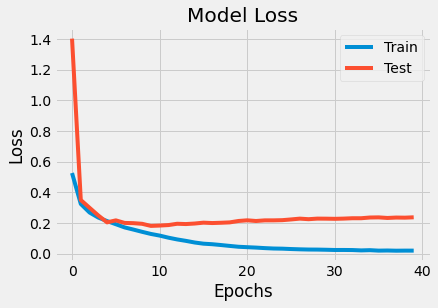

In [15]:
# Hiển thị sơ đồ so sánh loss trên tập train và tập test của từng epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

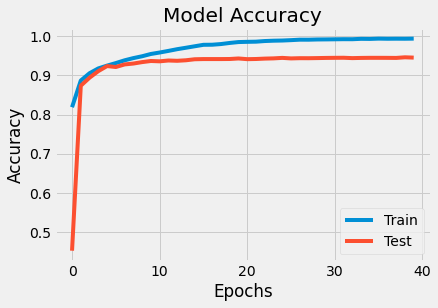

In [16]:
# Hiển thị sơ đồ so sánh accuracy trên tập train và tập test của từng epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()